In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit, learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn import ensemble, metrics, linear_model
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from kneed import KneeLocator
from matplotlib.ticker import PercentFormatter
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
import spacy
sp = spacy.load('en_core_web_sm')

In [2]:
# read 2020 procurement data
df_jan_mar_2020 = pd.read_csv(
    'Bid Notice and Award Details Jan-Mar 2020.csv', encoding = "ISO-8859-1")
df_apr_jun_2020 = pd.read_csv(
    'Bid Notice and Award Details Apr-Jun 2020.csv', encoding = "ISO-8859-1")
df_jul_sept_2020 = pd.read_csv(
    'Bid Notice and Award Details Jul-Sep 2020.csv', encoding = "ISO-8859-1")
df_oct_dec_2020 = pd.read_csv(
    'Bid Notice and Award Details Oct-Dec 2020.csv', encoding = "ISO-8859-1")

In [3]:
# combine 2020 data into 1 dataframe
df_proc_2020 = pd.concat([df_jan_mar_2020, df_apr_jun_2020,
                         df_jul_sept_2020, df_oct_dec_2020])

In [4]:
# change reference ID into str
df_proc_2020['Reference ID'] = df_proc_2020['Reference ID'].astype(str)

In [5]:
# make column names of df_proc_2020 consistent
df_jul_sept_2017 = pd.read_csv(
    'Bid Notice and Award Details Jul-Sep 2017.csv', encoding = "ISO-8859-1")
col_names_2017 = df_jul_sept_2017.columns
df_proc_2020.columns = col_names_2017

In [6]:
# combine 2020 data into 1 dataframe
df_proc_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 810863 entries, 0 to 236718
Data columns (total 40 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Organization Name                810863 non-null  object 
 1   Reference ID                     810863 non-null  object 
 2   Solicitation No.                 810797 non-null  object 
 3   Notice Title                     810863 non-null  object 
 4   Publish Date                     810863 non-null  object 
 5   Classification                   810863 non-null  object 
 6   Notice Type                      810863 non-null  object 
 7   Business Category                810863 non-null  object 
 8   Funding Source                   810863 non-null  object 
 9   Funding Instrument               810863 non-null  object 
 10  Procurement Mode                 810863 non-null  object 
 11  Trade Agreement                  810863 non-null  object 
 12  Ap

## Clean 2020 Procurement Data

In [7]:
# Change Contract Amount Column of SUC Procurement Data to Numeric Column
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].replace(',','', regex=True)
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].replace('-','', regex=True)
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].replace(' ','', regex=True)
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].replace('',np.nan, regex=True)
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].replace('NULL',np.nan, regex=True)
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].astype(float)

In [8]:
# calculate for Contract Duration to Days Multiplier
# for consistency: 1 month = 30 days: 1 year = 12 months = 360 days
df_proc_2020['Calendar Type'].unique()
num_days = {'Day/s': 1, 'Month/s': 30, 'Year/s': 360, np.nan: 1}
df_proc_2020['Days Multiplier'] = df_proc_2020['Calendar Type']
df_proc_2020['Days Multiplier'] = df_proc_2020[
    'Days Multiplier'].replace(num_days)
df_proc_2020['Contract Duration (Days)'] = df_proc_2020.apply(
    lambda row: (row['Days Multiplier']*row['Contract Duration']), axis=1)

In [9]:
# convert date columns to date time data types
date_cols = ['Publish Date', 'PreBid Date', 'Closing Date', 'Publish '
             'Date(Award)', 'Award Date', 'Notice to Proceed Date', 
             'Contract Efectivity Date', 'Contract End Date']
for i in date_cols:
    df_proc_2020[i] = pd.to_datetime(df_proc_2020[i].str.replace(
        '24:|25:|26:|27:|28:|29:|30:|31:|32:|33:|34:|35:|36:'
        '|37:|38:|39:|40:|41:|42:|43:|44:|45:|46:|47:|48:|49:|'
        '50:|51:|52:|53:|54:|55:|56:|57:|58:|59:','00:'))

<ipython-input-9-8dab1b0d02da>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_proc_2020[i] = pd.to_datetime(df_proc_2020[i].str.replace(


In [10]:
# get difference on dates

# difference (days) between notice to proceed date and publish date
df_proc_2020['Publish-NTP (Days)'] = df_proc_2020[
    'Notice to Proceed Date'] - df_proc_2020['Publish Date']
df_proc_2020['Publish-NTP (Days)'] = pd.to_numeric(df_proc_2020[
    'Publish-NTP (Days)'].dt.days, downcast='integer')

# difference (days) between award date and publish date
df_proc_2020['Publish-Award (Days)'] = df_proc_2020[
    'Award Date'] - df_proc_2020['Publish Date']
df_proc_2020['Publish-Award (Days)'] = pd.to_numeric(df_proc_2020[
    'Publish-Award (Days)'].dt.days, downcast='integer')

# difference (days) between closing date and publish date
df_proc_2020['Publish-Closing (Days)'] = df_proc_2020[
    'Closing Date'] - df_proc_2020['Publish Date']
df_proc_2020['Publish-Closing (Days)'] = pd.to_numeric(df_proc_2020[
    'Publish-Closing (Days)'].dt.days, downcast='integer')

# difference (days) between notice to proceed date and award date
df_proc_2020['Award-NTP (Days)'] = df_proc_2020[
    'Notice to Proceed Date'] - df_proc_2020['Award Date']
df_proc_2020['Award-NTP (Days)'] = pd.to_numeric(df_proc_2020[
    'Award-NTP (Days)'].dt.days, downcast='integer')

In [11]:
# create Year and Quarter Columns
df_proc_2020['Year'] = df_proc_2020['Publish Date'].dt.year
df_proc_2020['Quarter'] = df_proc_2020['Publish Date'].dt.quarter

# change Quarter column into string
df_proc_2020['Quarter'] = df_proc_2020['Quarter'].map({1: '1st', 2: '2nd',
                                                   3: '3rd', 4: '4th'})

In [12]:
# create deep copy of cleaned dataframe
df_proc_2020_clean = df_proc_2020.copy()

In [13]:
# check cleaned dataframe
df_proc_2020_clean.head()

,Organization Name,Reference ID,Solicitation No.,Notice Title,Publish Date,Classification,Notice Type,Business Category,Funding Source,Funding Instrument,...,Reason for Award,Award Status,Days Multiplier,Contract Duration (Days),Publish-NTP (Days),Publish-Award (Days),Publish-Closing (Days),Award-NTP (Days),Year,Quarter
0,DEPARTMENT OF PUBLIC WORKS AND HIGHWAYS - BENG...,6776642,20PF0030,20PF0030 Convergence and Special Support Progr...,2020-01-01,Civil Works,Invitation to Bid (ITB),Construction Projects,Government of the Philippines (GOP),National Expenditure Program (NEP) for the suc...,...,NaN,NaN,1,106.0,NaN,NaN,13.0,NaN,2020,1st
1,PROVINCE OF BATANES,6779335,2019-1375-12 (02),S & D of Construction Materials for the Comple...,2020-01-01,Goods,Invitation to Bid (ITB),Construction Materials and Supplies,Government of the Philippines (GOP),Budget for the Contract Approved by the Sanggu...,...,NaN,NaN,1,30.0,NaN,NaN,7.0,NaN,2020,1st
2,PROVINCE OF BATANES,6779368,2019-1357-11 (02),S & D of Materials for the Fabrication of Love...,2020-01-01,Goods,Invitation to Bid (ITB),Construction Materials and Supplies,Government of the Philippines (GOP),Budget for the Contract Approved by the Sanggu...,...,NaN,NaN,1,30.0,NaN,NaN,7.0,NaN,2020,1st
3,PROVINCE OF BATANES,6779402,2019-1393-12 (02),S & D of Construction Materials for the Constr...,2020-01-01,Goods,Invitation to Bid (ITB),Construction Materials and Supplies,Government of the Philippines (GOP),Budget for the Contract Approved by the Sanggu...,...,NaN,NaN,1,45.0,NaN,NaN,7.0,NaN,2020,1st
4,DEPARTMENT OF HEALTH - MAIN,6780338,IB NO. 2020-042-A,PROCUREMENT OF SERVICE PROVIDER FOR THE HAULIN...,2020-01-01,Goods - General Support Services,Invitation to Bid (ITB),Services,Government of the Philippines (GOP),National Expenditure Program (NEP) for the suc...,...,NaN,NaN,30,360.0,NaN,NaN,21.0,NaN,2020,1st


## Prepare 2020 Procurement Data

In [14]:
# check for null values
df_proc_2020_clean.isnull().sum()

Organization Name                       0
Reference ID                            0
Solicitation No.                       66
Notice Title                            0
Publish Date                            0
Classification                          0
Notice Type                             0
Business Category                       0
Funding Source                          0
Funding Instrument                      0
Procurement Mode                        0
Trade Agreement                         0
Approved Budget of the Contract         0
Area of Delivery                    59245
Contract Duration                    3449
Calendar Type                       19540
Line Item No                       367582
Item Name                          367610
Item Desc                          367615
Quantity                           367582
UOM                                367583
Item Budget                        367582
PreBid Date                        597981
Closing Date                      

In [15]:
# replace null values under Area of Delivery with "Others"
df_proc_2020_clean['Area of Delivery'] = df_proc_2020_clean[
    'Area of Delivery'].fillna('Others')

# replace null values under Contract Duration with mean of Contract Duration
# column
df_proc_2020_clean['Contract Duration'] = df_proc_2020_clean[
    'Contract Duration'].fillna(
    value=df_proc_2020_clean['Contract Duration'].mean())

# replace null values under Item Name with "None"
df_proc_2020_clean['Item Name'] = df_proc_2020_clean[
    'Item Name'].fillna('None')

# replace null values under Item Desc with "None"
df_proc_2020_clean['Item Desc'] = df_proc_2020_clean[
    'Item Desc'].fillna('None')

# replace null values under Quantity with mean of Quantity Column
df_proc_2020_clean['Quantity'] = df_proc_2020_clean[
    'Quantity'].fillna(value=df_proc_2020_clean['Quantity'].mean())

# replace null values under Item Budget with mean of Item Budget Column
df_proc_2020_clean['Item Budget'] = df_proc_2020_clean[
    'Item Budget'].fillna(value=df_proc_2020_clean['Item Budget'].mean())

# replace null values under Award Title with "None"
df_proc_2020_clean['Award Title'] = df_proc_2020_clean[
    'Award Title'].fillna('None')

# replace null values under Award Type with "None"
df_proc_2020_clean['Award Type'] = df_proc_2020_clean[
    'Award Type'].fillna('None')

# replace null values under Awardee Corporate Title with "None"
df_proc_2020_clean['Awardee Corporate Title'] = df_proc_2020_clean[
    'Awardee Corporate Title'].fillna('None')

# replace null values under Contract Amount with 0
df_proc_2020_clean['Contract Amount'] = df_proc_2020_clean[
    'Contract Amount'].fillna(0)

# replace null values under Reason for Award with "Not Awarded"
df_proc_2020_clean['Reason for Award'] = df_proc_2020_clean[
    'Reason for Award'].fillna('Not Awarded')

# replace null values under Award Status with "Not Awarded"
df_proc_2020_clean['Award Status'] = df_proc_2020_clean[
    'Award Status'].fillna('Not Awarded')

# replace null values under Contract Duration (Days) with mean of Contract 
# Duration (Days) column
df_proc_2020_clean['Contract Duration (Days)'] = df_proc_2020_clean[
    'Contract Duration (Days)'].fillna(
    value=df_proc_2020_clean['Contract Duration (Days)'].mean())

# replace null values under Publish-NTP (Days) with 0
df_proc_2020_clean['Publish-NTP (Days)'] = df_proc_2020_clean[
    'Publish-NTP (Days)'].fillna(0)

# replace null values under Publish-Award (Days) with 0
df_proc_2020_clean['Publish-Award (Days)'] = df_proc_2020_clean[
    'Publish-Award (Days)'].fillna(0)

# replace null values under Publish-Closing (Days) with 0
df_proc_2020_clean['Publish-Closing (Days)'] = df_proc_2020_clean[
    'Publish-Closing (Days)'].fillna(0)

# replace null values under Publish-Closing (Days) with 0
df_proc_2020_clean['Award-NTP (Days)'] = df_proc_2020_clean[
    'Award-NTP (Days)'].fillna(0)

In [16]:
# check if null values were successfully replaced
df_proc_2020_clean.isnull().sum()

Organization Name                       0
Reference ID                            0
Solicitation No.                       66
Notice Title                            0
Publish Date                            0
Classification                          0
Notice Type                             0
Business Category                       0
Funding Source                          0
Funding Instrument                      0
Procurement Mode                        0
Trade Agreement                         0
Approved Budget of the Contract         0
Area of Delivery                        0
Contract Duration                       0
Calendar Type                       19540
Line Item No                       367582
Item Name                               0
Item Desc                               0
Quantity                                0
UOM                                367583
Item Budget                             0
PreBid Date                        597981
Closing Date                      

In [17]:
# check info of cleaned dataframe
df_proc_2020_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 810863 entries, 0 to 236718
Data columns (total 48 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Organization Name                810863 non-null  object        
 1   Reference ID                     810863 non-null  object        
 2   Solicitation No.                 810797 non-null  object        
 3   Notice Title                     810863 non-null  object        
 4   Publish Date                     810863 non-null  datetime64[ns]
 5   Classification                   810863 non-null  object        
 6   Notice Type                      810863 non-null  object        
 7   Business Category                810863 non-null  object        
 8   Funding Source                   810863 non-null  object        
 9   Funding Instrument               810863 non-null  object        
 10  Procurement Mode                 810863 non-

## Get LGU Data

In [18]:
df_lgu = df_proc_2020_clean[df_proc_2020_clean['Organization Name'].str.contains("CITY OF|PROVINCE OF|MUNICIPALITY OF")]
df_lgu_clean = df_lgu[~df_lgu['Organization Name'].str.contains("DEPARTMENT|BIDS AND AWARDS COMMITTEE|WATER DISTRICT|HIGH SCHOOL|SCHOOL|BARANGAY|BRGY")]
df_lgu_clean

,Organization Name,Reference ID,Solicitation No.,Notice Title,Publish Date,Classification,Notice Type,Business Category,Funding Source,Funding Instrument,...,Reason for Award,Award Status,Days Multiplier,Contract Duration (Days),Publish-NTP (Days),Publish-Award (Days),Publish-Closing (Days),Award-NTP (Days),Year,Quarter
1,PROVINCE OF BATANES,6779335,2019-1375-12 (02),S & D of Construction Materials for the Comple...,2020-01-01,Goods,Invitation to Bid (ITB),Construction Materials and Supplies,Government of the Philippines (GOP),Budget for the Contract Approved by the Sanggu...,...,Not Awarded,Not Awarded,1,30.0,0.0,0.0,7.0,0.0,2020,1st
2,PROVINCE OF BATANES,6779368,2019-1357-11 (02),S & D of Materials for the Fabrication of Love...,2020-01-01,Goods,Invitation to Bid (ITB),Construction Materials and Supplies,Government of the Philippines (GOP),Budget for the Contract Approved by the Sanggu...,...,Not Awarded,Not Awarded,1,30.0,0.0,0.0,7.0,0.0,2020,1st
3,PROVINCE OF BATANES,6779402,2019-1393-12 (02),S & D of Construction Materials for the Constr...,2020-01-01,Goods,Invitation to Bid (ITB),Construction Materials and Supplies,Government of the Philippines (GOP),Budget for the Contract Approved by the Sanggu...,...,Not Awarded,Not Awarded,1,45.0,0.0,0.0,7.0,0.0,2020,1st
42,PROVINCE OF QUEZON,6761508,9827-19,9827-19 Purchase of Meals for the Year End Pro...,2020-01-02,Goods,Notice for Negotiated Procurement,Catering Services,Government of the Philippines (GOP),Budget for the Contract Approved by the Sanggu...,...,Not Awarded,Not Awarded,1,30.0,0.0,0.0,4.0,0.0,2020,1st
44,"MUNICIPALITY OF SAMAL, BATAAN",6773967,TF-PCF,"Construction of Multi-purpose Hall (Library, M...",2020-01-02,Civil Works,Invitation to Bid (ITB),Construction Projects,Government of the Philippines (GOP),Loans / Grants,...,Lowest Calculated Responsive Bid,Updated,1,60.0,27.0,25.0,20.0,2.0,2020,1st
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236646,"MUNICIPALITY OF SALCEDO, ILOCOS SUR",7392763,salbac 2020 106,CONSTRUCTION OF CHILD DEVELOPMENT CENTER at Ba...,2020-12-31,Civil Works,Invitation to Bid (ITB),Construction Projects,Government of the Philippines (GOP),Budget for the Contract Approved by the Sanggu...,...,Not Awarded,Not Awarded,1,100.0,0.0,0.0,27.0,0.0,2020,4th
236648,"MUNICIPALITY OF PAMBUJAN, NORTHERN SAMAR",7392766,21-01-001,Cluster Project Construction of 1-Sty/1-Std Cl...,2020-12-31,Civil Works,Invitation to Bid (ITB),Construction Projects,Government of the Philippines (GOP),Budget for the Contract Approved by the Sanggu...,...,Not Awarded,Not Awarded,1,90.0,0.0,0.0,19.0,0.0,2020,4th
236696,"MUNICIPALITY OF NASUGBU, BATANGAS",7392786,Nasugbu 2020-1977,Supply and Delivery of 1 unit of Motorcycle,2020-12-31,Goods,Request for Quotation (RFQ),Vehicles,Government of the Philippines (GOP),Budget for the Contract Approved by the Sanggu...,...,lowest quotation,Posted,1,14.0,0.0,5.0,4.0,0.0,2020,4th
236698,"MUNICIPALITY OF NASUGBU, BATANGAS",7392788,Nasugbu 2020-1969,Fabrication/Installation of Christmas Decor an...,2020-12-31,Goods,Request for Quotation (RFQ),Construction Materials and Supplies,Government of the Philippines (GOP),Budget for the Contract Approved by the Sanggu...,...,lowest quotation,Posted,1,14.0,0.0,6.0,4.0,0.0,2020,4th


## Transform Procurement Data

### Extract Numeric Columns from Cleaned Data

In [19]:
# extract numeric columns from data from cleaned data
numeric = ['Approved Budget of the Contract', 'Contract Duration (Days)',
           'Quantity', 'Item Budget', 'Contract Amount', 'Publish-NTP (Days)',
           'Publish-Award (Days)', 'Publish-Closing (Days)',
           'Award-NTP (Days)', 'Year']
df_proc_2020_numeric = df_lgu_clean[numeric]

In [20]:
# check numeric dataframe
df_proc_2020_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296220 entries, 1 to 236700
Data columns (total 10 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Approved Budget of the Contract  296220 non-null  float64
 1   Contract Duration (Days)         296220 non-null  float64
 2   Quantity                         296220 non-null  float64
 3   Item Budget                      296220 non-null  float64
 4   Contract Amount                  296220 non-null  float64
 5   Publish-NTP (Days)               296220 non-null  float64
 6   Publish-Award (Days)             296220 non-null  float64
 7   Publish-Closing (Days)           296220 non-null  float64
 8   Award-NTP (Days)                 296220 non-null  float64
 9   Year                             296220 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 24.9 MB


### Extract Categoric Columns from Cleaned Data

In [21]:
# extract categoric columns from data from cleaned data
categoric = ['Classification', 'Notice Type', 'Business Category',
               'Funding Source', 'Funding Instrument',
               'Procurement Mode', 'Trade Agreement', 
               'Area of Delivery', 'Notice Status', 'Award Type', 'Quarter']
df_proc_2020_categoric = df_lgu_clean[categoric]

In [22]:
# check categoric dataframe
df_proc_2020_categoric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296220 entries, 1 to 236700
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Classification      296220 non-null  object
 1   Notice Type         296220 non-null  object
 2   Business Category   296220 non-null  object
 3   Funding Source      296220 non-null  object
 4   Funding Instrument  296220 non-null  object
 5   Procurement Mode    296220 non-null  object
 6   Trade Agreement     296220 non-null  object
 7   Area of Delivery    296220 non-null  object
 8   Notice Status       296220 non-null  object
 9   Award Type          296220 non-null  object
 10  Quarter             296220 non-null  object
dtypes: object(11)
memory usage: 27.1+ MB


In [23]:
# create dummy variables for categoric datafrmae
df_proc_2020_categoric_ohe = pd.get_dummies(
    df_proc_2020_categoric, columns = categoric)

In [24]:
# check one-hot encoded categoric dataframe
df_proc_2020_categoric_ohe

,Classification_Civil Works,Classification_Consulting Services,Classification_Goods,Classification_Goods - General Support Services,Notice Type_Invitation to Apply for Eligibility and to Bid,Notice Type_Invitation to Bid (ITB),Notice Type_Notice for Negotiated Procurement,Notice Type_Request for Expression of Interest,Notice Type_Request for Proposal (RFP),Notice Type_Request for Quotation (RFQ),...,Award Type_Award Notice (Negotiated Procurement - Highly Tech,Award Type_Negotiated Procurement (Adjacent / Contiguous),Award Type_Negotiated Procurement (Take-over of contracts),Award Type_None,Award Type_Re-Award,Award Type_Repeat Order,Quarter_1st,Quarter_2nd,Quarter_3rd,Quarter_4th
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
42,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
44,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236646,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
236648,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
236696,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
236698,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### Extract Columns with Descriptions from Cleaned Data

In [25]:
# extract contract description from columns text from cleaned data
desc = ['Notice Title', 'Item Name', 'Item Desc', 'Award Title',
        'Reason for Award']
df_proc_2020_desc = df_lgu_clean[desc]

In [26]:
# check df_proc_2020_desc dataframe
df_proc_2020_desc

,Notice Title,Item Name,Item Desc,Award Title,Reason for Award
1,S & D of Construction Materials for the Comple...,Construction Materials,various,None,Not Awarded
2,S & D of Materials for the Fabrication of Love...,Materials,various,None,Not Awarded
3,S & D of Construction Materials for the Constr...,Construction Materials,various,None,Not Awarded
42,9827-19 Purchase of Meals for the Year End Pro...,Food,Meals and Snacks,None,Not Awarded
44,"Construction of Multi-purpose Hall (Library, M...",Construction of Multi-purpose Hall Phase II,"Construction of Multi-purpose Hall (Library, M...",Construction of Multi-purpose Hall Phase II,Lowest Calculated Responsive Bid
...,...,...,...,...,...
236646,CONSTRUCTION OF CHILD DEVELOPMENT CENTER at Ba...,Const'n. of Child Devt. Center (Baybayading),Spl-1 Removal/Clearing/Layout; I-103 Common/St...,None,Not Awarded
236648,Cluster Project Construction of 1-Sty/1-Std Cl...,None,None,None,Not Awarded
236696,Supply and Delivery of 1 unit of Motorcycle,Supply and Delivery of 1 unit Motorcycle,"Specs: Model Click 125, Registration date 2020...",Supply and Delivery of 1 unit Motorcycle,lowest quotation
236698,Fabrication/Installation of Christmas Decor an...,Construction Materials and Supplies,"200 bd.ft. Good Lumber 2x2x4', 10 pcs. Marine ...",Construction Materials and Supplies,lowest quotation


#### Preprocess Text Data from Notice Title, Item Name, Item Desc, Award Title, and Reason for Awarrd Columns

In [27]:
# initialize helper functions
def remove_stopwords(text):
    all_stopwords = sp.Defaults.stop_words
    text = text.lower()
    text_tokens = word_tokenize(text)
    tokens_without_sw = [
        word for word in text_tokens if not word in all_stopwords]
    return ' '.join(tokens_without_sw)

def lemmatize_text(text):
    tokens = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    porter_stemmer = PorterStemmer()
    tokens = text.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def single_vectorizer(df):
    num_vector_features = 300
    tfid = TfidfVectorizer(max_features=num_vector_features)
# why 300?
# [5] CC. Recommender systems. Cham: Springer International Publishing; 2016.
# [6] M. Pazzani and D. Billsus. Learning and revising user profiles: The identification of interesting Web sites. Machine learning, 27(3), pp. 313?331, 1997.
    vector = tfid.fit_transform(df)
    df_vector = pd.DataFrame(
        vector.toarray(), index=df.index, columns=tfid.get_feature_names())
    return df_vector

def quad_vectorizer(df1, df2, df3, df4):
    num_vector_features = 300
    tfid = TfidfVectorizer(max_features=num_vector_features)
# why 300?
# [5] CC. Recommender systems. Cham: Springer International Publishing; 2016.
# [6] M. Pazzani and D. Billsus. Learning and revising user profiles: The identification of interesting Web sites. Machine learning, 27(3), pp. 313?331, 1997.
    vector = tfid.fit_transform(
        df1 + " " + df2 + " " + df3 + " " + df4)
    df_vector = pd.DataFrame(
        vector.toarray(), index=df1.index, columns=tfid.get_feature_names())
    return df_vector

In [28]:
# remove digits
df_proc_2020_desc = df_proc_2020_desc.fillna('')
df_proc_2020_desc['Notice Title'] = df_proc_2020_desc[
    'Notice Title'].str.replace('\d+', '').astype(str)
df_proc_2020_desc['Item Name'] = df_proc_2020_desc[
    'Item Name'].str.replace('\d+', '').astype(str)
df_proc_2020_desc['Item Desc'] = df_proc_2020_desc[
    'Item Desc'].str.replace('\d+', '').astype(str)
df_proc_2020_desc['Award Title'] = df_proc_2020_desc[
    'Award Title'].str.replace('\d+', '').astype(str)
df_proc_2020_desc['Reason for Award'] = df_proc_2020_desc[
    'Reason for Award'].str.replace('\d+', '').astype(str)

<ipython-input-28-90996cb57170>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_proc_2020_desc['Notice Title'] = df_proc_2020_desc[
<ipython-input-28-90996cb57170>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_proc_2020_desc['Item Name'] = df_proc_2020_desc[
<ipython-input-28-90996cb57170>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_proc_2020_desc['Item Desc'] = df_proc_2020_desc[
<ipython-input-28-90996cb57170>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_proc_2020_desc['Award Title'] = df_proc_2020_desc[
<ipython-input-28-90996cb57170>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_proc_2020_desc['Reason for Award'] = df_proc_2020_desc[


In [29]:
# remove stop words
df_proc_2020_desc['Notice Title'] = df_proc_2020_desc[
    'Notice Title'].apply(remove_stopwords)
df_proc_2020_desc['Item Name'] = df_proc_2020_desc['Item Name'].apply(remove_stopwords)
df_proc_2020_desc['Item Desc'] = df_proc_2020_desc['Item Desc'].apply(remove_stopwords)
df_proc_2020_desc['Award Title'] = df_proc_2020_desc[
    'Award Title'].apply(remove_stopwords)
df_proc_2020_desc['Reason for Award'] = df_proc_2020_desc[
    'Reason for Award'].apply(remove_stopwords)

In [30]:
# lemmatize each column
df_proc_2020_desc['Notice Title'] = df_proc_2020_desc[
    'Notice Title'].apply(lemmatize_text)
df_proc_2020_desc['Item Name'] = df_proc_2020_desc[
    'Item Name'].apply(lemmatize_text)
df_proc_2020_desc['Item Desc'] = df_proc_2020_desc[
    'Item Desc'].apply(lemmatize_text)
df_proc_2020_desc['Award Title'] = df_proc_2020_desc[
    'Award Title'].apply(lemmatize_text)
df_proc_2020_desc['Reason for Award'] = df_proc_2020_desc[
    'Reason for Award'].apply(lemmatize_text)

In [31]:
# get tfid vectorized data of combined columns
df1 = df_proc_2020_desc['Notice Title']
df2 = df_proc_2020_desc['Item Name']
df3 = df_proc_2020_desc['Item Desc']
df4 = df_proc_2020_desc['Award Title']
df_proc_2020_contract_details_vector = quad_vectorizer(df1, df2, df3, df4)

In [32]:
# check tfid vectorized data
df_proc_2020_contract_details_vector

,abc,access,accessory,accommodation,activity,additional,affected,agricultural,air,aircon,...,use,vegetable,vehicle,venue,wall,waste,water,window,wire,work
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.698667
236648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
236696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
236698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [33]:
# get tfid vectorized data of Reason for AWard column
df_proc_2020_reason_for_award_vector = single_vectorizer(
    df_proc_2020_desc['Reason for Award'])

In [34]:
# check tfid vectorized data
df_proc_2020_reason_for_award_vector

,abc,accepted,accordance,act,additional,address,advantageous,affected,agency,alternative,...,trading,undertake,unit,use,user,value,vicinity,virus,winning,work
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Combine Extracted Columns and Vectorized Data into One Dataframe

In [35]:
df_proc_2020_feature = pd.concat([df_lgu_clean['Organization Name'],
                          df_lgu_clean['Reference ID'],
                          df_proc_2020_numeric, df_proc_2020_categoric_ohe,
                          df_proc_2020_contract_details_vector,
                          df_proc_2020_reason_for_award_vector], axis=1)

In [36]:
# check combined dataframe
df_proc_2020_feature

,Organization Name,Reference ID,Approved Budget of the Contract,Contract Duration (Days),Quantity,Item Budget,Contract Amount,Publish-NTP (Days),Publish-Award (Days),Publish-Closing (Days),...,trading,undertake,unit,use,user,value,vicinity,virus,winning,work
1,PROVINCE OF BATANES,6779335,56150.00,30.0,1.000000,5.615000e+04,0.00,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PROVINCE OF BATANES,6779368,102150.00,30.0,1.000000,1.021500e+05,0.00,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PROVINCE OF BATANES,6779402,367990.00,45.0,1.000000,3.679900e+05,0.00,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,PROVINCE OF QUEZON,6761508,160000.00,30.0,50.000000,1.600000e+05,0.00,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,"MUNICIPALITY OF SAMAL, BATAAN",6773967,3200000.00,60.0,1.000000,3.200000e+06,3181580.72,27.0,25.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236646,"MUNICIPALITY OF SALCEDO, ILOCOS SUR",7392763,999981.00,100.0,1.000000,9.999810e+05,0.00,0.0,0.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236648,"MUNICIPALITY OF PAMBUJAN, NORTHERN SAMAR",7392766,2074763.72,90.0,2249.813935,1.001741e+06,0.00,0.0,0.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236696,"MUNICIPALITY OF NASUGBU, BATANGAS",7392786,83052.00,14.0,1.000000,8.305200e+04,83052.00,0.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236698,"MUNICIPALITY OF NASUGBU, BATANGAS",7392788,99550.00,14.0,1.000000,9.955000e+04,99550.00,0.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# write dataframe into a csv file
# df_proc_2020_feature.to_csv(
#     'df_lgu_2020_feature.csv', index=False)

## Add `is_Irregular` Column

In [38]:
df_proc_2020_feature_labeled = df_proc_2020_feature.assign(is_Irregular=0)
df_proc_2020_feature_labeled.loc[df_proc_2020_feature_labeled['Award-NTP (Days)'] < 0, 'is_Irregular'] = 1

In [39]:
df_proc_2020_feature_labeled

,Organization Name,Reference ID,Approved Budget of the Contract,Contract Duration (Days),Quantity,Item Budget,Contract Amount,Publish-NTP (Days),Publish-Award (Days),Publish-Closing (Days),...,undertake,unit,use,user,value,vicinity,virus,winning,work,is_Irregular
1,PROVINCE OF BATANES,6779335,56150.00,30.0,1.000000,5.615000e+04,0.00,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,PROVINCE OF BATANES,6779368,102150.00,30.0,1.000000,1.021500e+05,0.00,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,PROVINCE OF BATANES,6779402,367990.00,45.0,1.000000,3.679900e+05,0.00,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
42,PROVINCE OF QUEZON,6761508,160000.00,30.0,50.000000,1.600000e+05,0.00,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
44,"MUNICIPALITY OF SAMAL, BATAAN",6773967,3200000.00,60.0,1.000000,3.200000e+06,3181580.72,27.0,25.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236646,"MUNICIPALITY OF SALCEDO, ILOCOS SUR",7392763,999981.00,100.0,1.000000,9.999810e+05,0.00,0.0,0.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
236648,"MUNICIPALITY OF PAMBUJAN, NORTHERN SAMAR",7392766,2074763.72,90.0,2249.813935,1.001741e+06,0.00,0.0,0.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
236696,"MUNICIPALITY OF NASUGBU, BATANGAS",7392786,83052.00,14.0,1.000000,8.305200e+04,83052.00,0.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
236698,"MUNICIPALITY OF NASUGBU, BATANGAS",7392788,99550.00,14.0,1.000000,9.955000e+04,99550.00,0.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Perform Dimensionality Reduction

In [40]:
df_proc_2020_feature = pd.concat([
                          df_proc_2020_numeric, df_proc_2020_categoric_ohe,
                          df_proc_2020_contract_details_vector,
                          df_proc_2020_reason_for_award_vector], axis=1)

In [41]:
df_proc_2020_feature

,Approved Budget of the Contract,Contract Duration (Days),Quantity,Item Budget,Contract Amount,Publish-NTP (Days),Publish-Award (Days),Publish-Closing (Days),Award-NTP (Days),Year,...,trading,undertake,unit,use,user,value,vicinity,virus,winning,work
1,56150.00,30.0,1.000000,5.615000e+04,0.00,0.0,0.0,7.0,0.0,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,102150.00,30.0,1.000000,1.021500e+05,0.00,0.0,0.0,7.0,0.0,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,367990.00,45.0,1.000000,3.679900e+05,0.00,0.0,0.0,7.0,0.0,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,160000.00,30.0,50.000000,1.600000e+05,0.00,0.0,0.0,4.0,0.0,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,3200000.00,60.0,1.000000,3.200000e+06,3181580.72,27.0,25.0,20.0,2.0,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236646,999981.00,100.0,1.000000,9.999810e+05,0.00,0.0,0.0,27.0,0.0,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236648,2074763.72,90.0,2249.813935,1.001741e+06,0.00,0.0,0.0,19.0,0.0,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236696,83052.00,14.0,1.000000,8.305200e+04,83052.00,0.0,5.0,4.0,0.0,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236698,99550.00,14.0,1.000000,9.955000e+04,99550.00,0.0,6.0,4.0,0.0,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
scaler = MinMaxScaler()
df_proc_2020_feature_scaled = scaler.fit_transform(df_proc_2020_feature)

In [43]:
df_proc_2020_feature_scaled

array([[3.73936960e-06, 6.94444444e-04, 2.28571429e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.80278904e-06, 6.94444444e-04, 2.28571429e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.45066896e-05, 1.04166667e-03, 2.28571429e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.53093721e-06, 3.24074074e-04, 2.28571429e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.62963925e-06, 3.24074074e-04, 2.28571429e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.99470561e-06, 1.62037037e-04, 2.28571429e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [44]:
tsvd = TruncatedSVD(n_components=300, n_iter=7, random_state=45)
tsvd.fit(df_proc_2020_feature_scaled)

TruncatedSVD(n_components=300, n_iter=7, random_state=45)

In [45]:
min_svs = sum(tsvd.explained_variance_ratio_.cumsum() < 0.80) + 1
min_svs

86

In [46]:
tsvd = TruncatedSVD(n_components=min_svs, n_iter=7, random_state=45)
tsvd.fit(df_proc_2020_feature_scaled)

TruncatedSVD(n_components=86, n_iter=7, random_state=45)

In [47]:
df_proc_2020_feature_reduced = tsvd.fit_transform(df_proc_2020_feature_scaled)
df_proc_2020_feature_reduced

array([[ 2.98665844,  0.92927909,  0.10693567, ..., -0.01687609,
         0.05105497,  0.0176951 ],
       [ 2.97886129,  0.91003753,  0.09941363, ...,  0.01330195,
        -0.00424802,  0.03220306],
       [ 2.99092596,  0.93575916,  0.10885371, ..., -0.01233576,
         0.05093383,  0.01793862],
       ...,
       [ 2.34320125, -0.77225478,  1.76214611, ..., -0.00864579,
         0.00683931,  0.01984692],
       [ 2.3678381 , -0.75564415,  1.76975954, ...,  0.0631773 ,
         0.03493223, -0.0318145 ],
       [ 3.11942563, -0.76358042, -0.3220286 , ..., -0.04751928,
        -0.12766142,  0.09495257]])

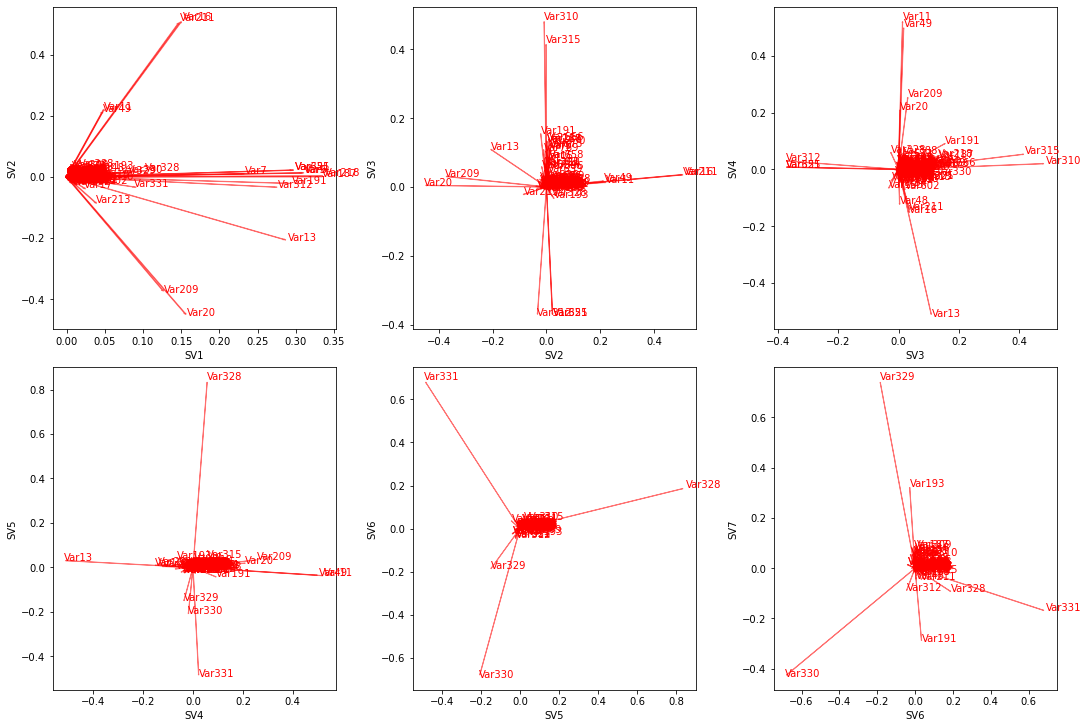

In [48]:
def myplot(score, coeff, sv_num, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.02, coeff[i,1] * 1.02,
                     "Var"+str(i+1), color = 'r')
        else:
            plt.text(coeff[i,0]* 1.02, coeff[i,1] * 1.02,
                     labels[i], color = 'r')
            
    plt.xlabel("SV{}".format(sv_num))
    plt.ylabel("SV{}".format(sv_num+1))

# generate plot for least 10 games (1000 <= reviews <= 2000)
fig, ax = plt.subplots(2,3, figsize=(15,10), constrained_layout=True)
plt.sca(ax[0, 0]) 
myplot(df_proc_2020_feature_reduced[:,0:2],np.transpose(tsvd.components_[0:2, :]),1)
plt.sca(ax[0, 1]) 
myplot(df_proc_2020_feature_reduced[:,1:3],np.transpose(tsvd.components_[1:3, :]),2)
plt.sca(ax[0, 2]) 
myplot(df_proc_2020_feature_reduced[:,2:4],np.transpose(tsvd.components_[2:4, :]),3)
plt.sca(ax[1, 0]) 
myplot(df_proc_2020_feature_reduced[:,3:5],np.transpose(tsvd.components_[3:5, :]),4)
plt.sca(ax[1, 1]) 
myplot(df_proc_2020_feature_reduced[:,4:6],np.transpose(tsvd.components_[4:6, :]),5)
plt.sca(ax[1, 2]) 
myplot(df_proc_2020_feature_reduced[:,5:7],np.transpose(tsvd.components_[5:7, :]),6)
plt.show()

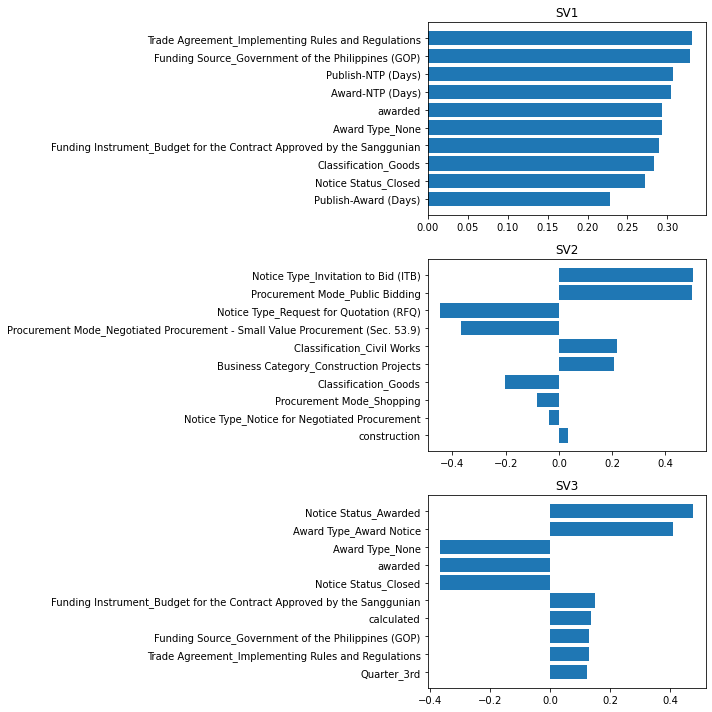

In [64]:
feature_names = df_proc_2020_feature.columns
fig = plt.figure(figsize=(10,10))
for i in range(3):
    ax = fig.add_subplot(3,1,i+1)
    order = np.argsort(np.abs(tsvd.components_.T[:, i]))[-10:]
    ax.barh([feature_names[o] for o in order], tsvd.components_.T[order, i])
    ax.set_title(f'SV{i+1}')
plt.tight_layout()

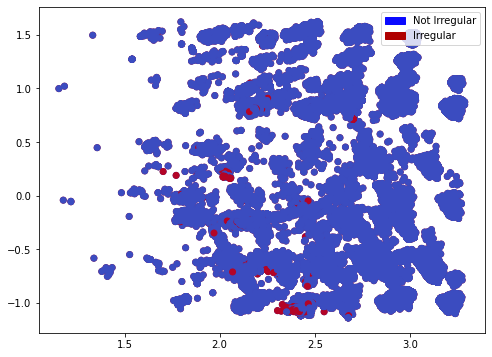

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

blue_patch = mpatches.Patch(color='#0A0AFF', label='Not Irregular')
red_patch = mpatches.Patch(color='#AF0000', label='Irregular')

ax.scatter(df_proc_2020_feature_reduced[:,0], df_proc_2020_feature_reduced[:,1], c=(df_proc_2020_feature_labeled['is_Irregular']==0), cmap='coolwarm', label='Not Irregular')
ax.scatter(df_proc_2020_feature_reduced[:,0], df_proc_2020_feature_reduced[:,1], c=(df_proc_2020_feature_labeled['is_Irregular']==1), cmap='coolwarm', label='Irregular')
ax.legend(handles=[blue_patch, red_patch], loc="upper right")
plt.show()

In [51]:
df_proc_2020_feature_reduced_labeled = pd.DataFrame(df_proc_2020_feature_reduced, index=df_proc_2020_feature_labeled.index)
df_proc_2020_feature_reduced_labeled.columns = ['SV{}'.format(i+1) for i in range(min_svs)]
df_proc_2020_feature_reduced_labeled = pd.concat([df_proc_2020_feature_reduced_labeled, df_proc_2020_feature_labeled['is_Irregular']], axis=1)
df_proc_2020_feature_reduced_labeled

,SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,...,SV78,SV79,SV80,SV81,SV82,SV83,SV84,SV85,SV86,is_Irregular
1,2.986658,0.929279,0.106936,-0.600854,0.796896,0.237761,-0.185563,-0.237074,-0.129282,-0.507339,...,-0.034409,-0.039434,-0.064411,-0.015846,-0.027170,-0.067564,-0.016876,0.051055,0.017695,0
2,2.978861,0.910038,0.099414,-0.628520,0.802297,0.238445,-0.185793,-0.241789,-0.126084,-0.459619,...,-0.032827,0.030417,-0.031555,0.023036,-0.008741,-0.035725,0.013302,-0.004248,0.032203,0
3,2.990926,0.935759,0.108854,-0.582501,0.794962,0.236888,-0.184823,-0.233484,-0.131567,-0.517981,...,-0.028276,-0.029032,-0.051118,0.001358,-0.022852,-0.043154,-0.012336,0.050934,0.017939,0
42,3.078543,-0.597043,-0.292234,0.078183,0.800997,0.111115,-0.119745,-0.341336,-0.729238,0.798808,...,-0.065537,0.036701,0.036154,0.087144,0.110073,0.024299,-0.005849,0.077636,0.094997,0
44,1.984276,1.506602,1.719569,1.059383,0.862687,0.311842,0.244033,0.637077,0.118541,-0.123647,...,0.008147,-0.080437,0.135092,0.076674,0.219236,0.113508,0.102182,-0.000937,-0.081732,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236646,2.741711,1.505844,0.053043,1.027015,-0.643548,0.672611,-0.047114,-0.076070,0.072810,0.044102,...,-0.065281,-0.011520,0.195971,0.089999,0.006046,-0.039875,0.050077,0.076891,-0.023074,0
236648,2.741807,1.506634,0.038790,1.022637,-0.643899,0.668652,-0.046607,-0.073065,0.070220,0.033305,...,0.019868,0.006320,-0.011977,0.019610,0.040774,0.006355,0.022119,0.016694,-0.042692,0
236696,2.343201,-0.772255,1.762146,-0.055195,-0.423434,0.813325,-0.147752,0.247575,0.986458,-0.136755,...,0.041060,0.073934,0.121850,-0.035123,0.116284,-0.079977,-0.008646,0.006839,0.019847,0
236698,2.367838,-0.755644,1.769760,-0.112254,-0.427065,0.815216,-0.186285,0.288274,0.906705,-0.640802,...,0.027935,0.019298,0.105751,-0.065413,0.052693,-0.014494,0.063177,0.034932,-0.031814,0


## Logistic Regression

In [52]:
X = df_proc_2020_feature_reduced_labeled.drop('is_Irregular', axis=1)
y = df_proc_2020_feature_reduced_labeled['is_Irregular']

skf = StratifiedKFold(n_splits=10, shuffle=False)

for train_index, test_index in skf.split(X, y):
    original_X_train, original_X_test = X.iloc[train_index], X.iloc[test_index]
    original_y_train, original_y_test = y.iloc[train_index], y.iloc[test_index]
    
    original_X_train, original_X_test = original_X_train.values, original_X_test.values
    original_y_train, original_y_test = original_y_train.values, original_y_test.values

    # see if the train and test set have similar distributed labels
    _, train_label_count = np.unique(original_y_train, return_counts=True)
    _, test_label_count = np.unique(original_y_test, return_counts=True)

    print('Label Distributions:')
    print(train_label_count / len(original_y_train))
    print(test_label_count / len(original_y_test))

Label Distributions:
[0.99734432 0.00265568]
[0.99736682 0.00263318]
Label Distributions:
[0.99734432 0.00265568]
[0.99736682 0.00263318]
Label Distributions:
[0.99734432 0.00265568]
[0.99736682 0.00263318]
Label Distributions:
[0.99734432 0.00265568]
[0.99736682 0.00263318]
Label Distributions:
[0.99734807 0.00265193]
[0.99733306 0.00266694]
Label Distributions:
[0.99734807 0.00265193]
[0.99733306 0.00266694]
Label Distributions:
[0.99734807 0.00265193]
[0.99733306 0.00266694]
Label Distributions:
[0.99734807 0.00265193]
[0.99733306 0.00266694]
Label Distributions:
[0.99734807 0.00265193]
[0.99733306 0.00266694]
Label Distributions:
[0.99734807 0.00265193]
[0.99733306 0.00266694]


In [53]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

log_reg_params = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

rand_log_reg = RandomizedSearchCV(LogisticRegression(max_iter=5000, solver='saga'), log_reg_params, n_iter=5)

for train, test in skf.split(original_X_train, original_y_train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
    model = pipeline.fit(original_X_train[train], original_y_train[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_X_train[test])
    
    accuracy_lst.append(pipeline.score(original_X_train[test], original_y_train[test]))
    precision_lst.append(precision_score(original_y_train[test], prediction))
    recall_lst.append(recall_score(original_y_train[test], prediction))
    f1_lst.append(f1_score(original_y_train[test], prediction))
    auc_lst.append(roc_auc_score(original_y_train[test], prediction))
    
print("Accuracy: {}".format(np.mean(accuracy_lst)))
print("Precision: {}".format(np.mean(precision_lst)))
print("Recall: {}".format(np.mean(recall_lst)))
print("F1: {}".format(np.mean(f1_lst)))

Accuracy: 0.8599650339269989
Precision: 0.020268751846988127
Recall: 0.9239034205231388
F1: 0.03945719707693497


In [54]:
best_est

LogisticRegression(C=0.001, max_iter=5000, solver='saga')

In [55]:
labels = ['Not Irregular', 'Irregular']
smote_prediction = best_est.predict(original_X_test)

print(classification_report(original_y_test, smote_prediction, target_names=labels))

               precision    recall  f1-score   support

Not Irregular       1.00      0.91      0.95     29543
    Irregular       0.03      1.00      0.06        79

     accuracy                           0.91     29622
    macro avg       0.51      0.96      0.51     29622
 weighted avg       1.00      0.91      0.95     29622



In [56]:
y_score = best_est.decision_function(original_X_test)
average_precision = average_precision_score(original_y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.17


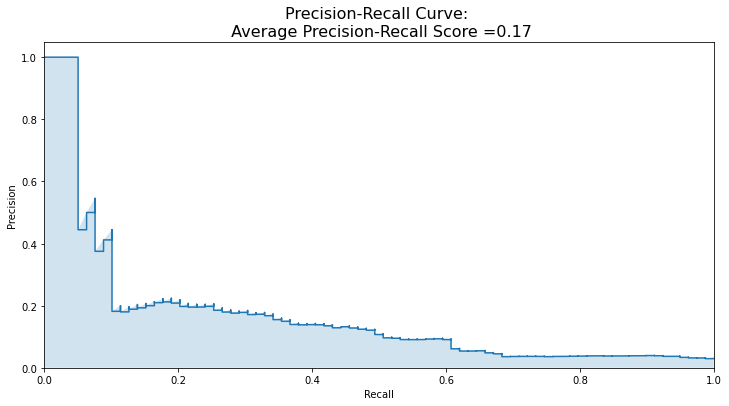

In [57]:
fig = plt.figure(figsize=(12, 6))
precision, recall, _ = precision_recall_curve(original_y_test, y_score)
plt.step(recall, precision)
plt.fill_between(recall, precision, alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)
plt.show()

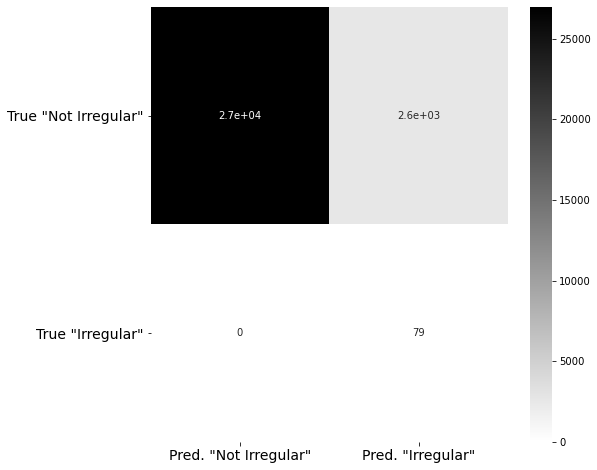

In [58]:
from sklearn.metrics import confusion_matrix

y_pred_log_reg = best_est.predict(original_X_test)

log_reg_cf = confusion_matrix(original_y_test, y_pred_log_reg)

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(log_reg_cf, ax=ax, cmap='binary', annot=True)
ax.set_xticklabels(['Pred. "Not Irregular"', 'Pred. "Irregular"'], fontsize=14)
ax.set_yticklabels(['True "Not Irregular"', 'True "Irregular"'], fontsize=14, rotation=360);

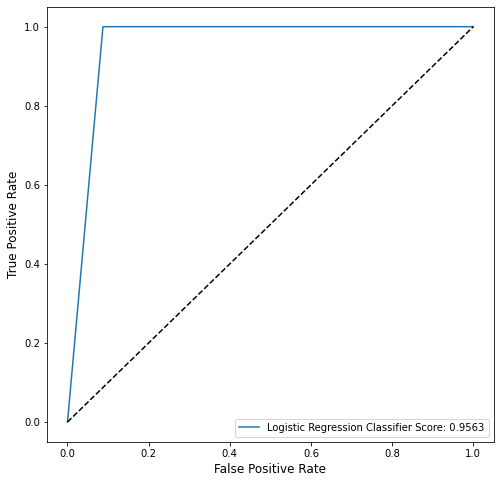

In [59]:
log_fpr, log_tpr, log_threshold = roc_curve(original_y_test, y_pred_log_reg)


plt.figure(figsize=(8,8))
plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(original_y_test, y_pred_log_reg)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend()

In [60]:
y_pred_sm = best_est.predict(original_X_test)
oversample_score = accuracy_score(original_y_test, y_pred_sm)
oversample_score

0.9128688137195328

In [61]:
best_est.coef_

array([[-1.32731561e+00, -1.79351051e-01,  2.38284298e+00,
        -3.46352353e-01,  1.30920856e-01,  1.08363943e+00,
        -1.77362937e-01,  3.53614723e-01,  2.43862123e-02,
        -2.31971969e-01, -6.74266655e-03,  2.58085530e-01,
        -5.49941531e-01, -1.77883220e-01, -3.30164644e-01,
        -2.10859709e-01,  3.62320680e-02, -2.04640213e-01,
         4.09908176e-01, -3.84328394e-01, -4.56363775e-01,
         3.20916610e-01,  1.33576401e-01,  1.66977086e-01,
        -3.25303100e-01, -4.15233110e-01,  1.62234394e-01,
         3.20507094e-01, -1.99249255e-01, -2.95038669e-01,
        -2.64569937e-01,  5.93985316e-01,  1.07162083e-01,
        -4.98432694e-02, -1.05388198e-01, -5.53531886e-02,
         1.84137951e-01, -3.46245418e-01, -1.04490713e-01,
        -1.27304560e-01, -2.42553114e-01, -1.85900498e-01,
         1.21964843e-03,  2.43277140e-01,  2.24120351e-01,
        -4.29555604e-01, -3.07958097e-03, -3.89744262e-01,
        -4.61052885e-01, -5.71996225e-02,  1.80776805e-0

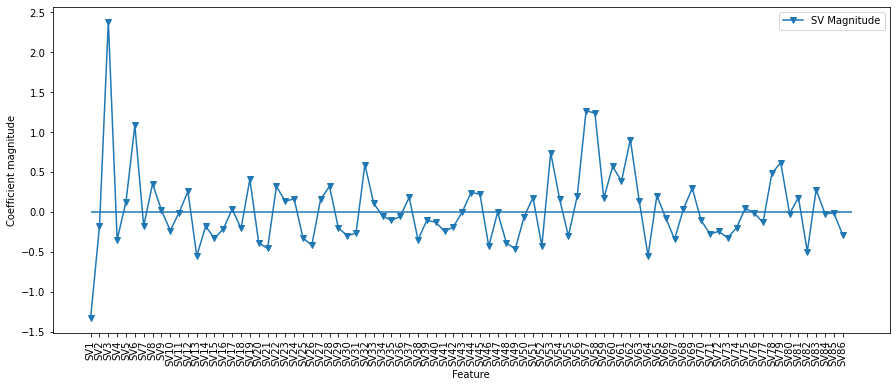

In [82]:
fig = plt.figure(figsize=(15, 6))
#plt.plot(logisticregression001.coef_.T, '-', label="C=0.001")
plt.plot(best_est.coef_.T, '-v', label='SV Magnitude')
plt.xticks(range(pd.DataFrame(best_est.coef_).shape[1]), ['SV{}'.format(i+1) for i in range(min_svs)], rotation=90)
plt.hlines(0,0, pd.DataFrame(best_est.coef_).shape[1])
#plt.ylim(-1, 1)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend();